In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
%matplotlib inline

In [82]:
import yaml
import os
import openslide
import pandas as pd

import matplotlib.image as mpimg
from matplotlib import pyplot as plt

try:
    get_ipython()
    from tqdm import tqdm_notebook as tqdm
except:
    from tqdm import tqdm

In [69]:
from wsi.slide import thumbnail
from wsi.patch import patch_slides

In [70]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

**Config**

In [71]:
slides_path = os.path.join(conf['data_path'], 'slides', 'svs')

In [72]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')

if not os.path.exists(patches_path):
    os.mkdir(patches_path)

In [73]:
thumbnails_path = os.path.join(conf['data_path'], 'slides', 'thumbnail')

if not os.path.exists(thumbnails_path):
    os.mkdir(thumbnails_path)

In [74]:
slides_df = pd.read_csv(os.path.join(conf['data_path'], 'slides_metadata.csv'), sep='|')
slides_df = slides_df[slides_df['file_name'].isin(os.listdir(slides_path))]

In [75]:
slides_df.head(2)

,file_id,case_id,sample_id,slide_id,data_type,experimental_strategy,data_format,file_size,file_name,primary_site,disease_type,sample_type,is_ffpe,percent_normal_cells,percent_stromal_cells,percent_tumor_cells,percent_tumor_nuclei
1,7ec5c9d0-8c22-4e30-bae8-605c3dcfe744,TCGA-HZ-A49I,TCGA-HZ-A49I-01A,TCGA-HZ-A49I-01A-01-TS1,Slide Image,Tissue Slide,SVS,293.72,TCGA-HZ-A49I-01A-01-TS1.svs,Pancreas,Ductal and Lobular Neoplasms,Primary Tumor,False,40.0,55.0,5.0,5.0
2,265adb6b-913e-490c-8cea-32d67c1440a2,TCGA-3A-A9IZ,TCGA-3A-A9IZ-01A,TCGA-3A-A9IZ-01A-01-TS1,Slide Image,Tissue Slide,SVS,166.95,TCGA-3A-A9IZ-01A-01-TS1.svs,Pancreas,Ductal and Lobular Neoplasms,Primary Tumor,False,25.0,0.0,65.0,40.0


In [76]:
slides_df.groupby(['experimental_strategy', 'sample_type']).size()

experimental_strategy  sample_type        
Tissue Slide           Metastatic               1
                       Primary Tumor          204
                       Solid Tissue Normal      4
dtype: int64

## Save slide thumbnails

In [33]:
for file in tqdm(slides_df['file_name'].values, unit='file'):
    
    os_img = openslide.open_slide(os.path.join(slides_path, file))
    img = thumbnail(os_img, max_size=THUMBNAIL_SIZE)
    
    img.save(os.path.join(thumbnails_path, file.replace('.svs', '.png')))

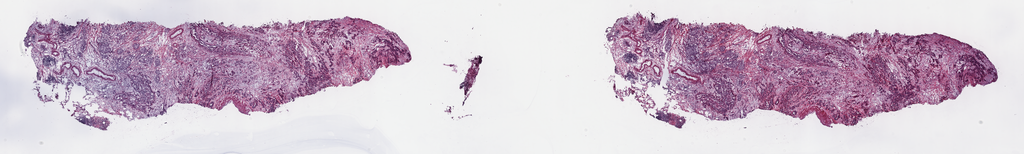

In [83]:
img

## Patching

In [56]:
slide_files = slides_df['file_name'].map(lambda x: os.path.join(slides_path, x))

In [64]:
results = patch_slides(slide_files, patches_path, conf['wsi']['patch_size'], conf['wsi']['magnification'])

100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


In [66]:
results.head(5)

,file,perc_valid_patches,total_patches,valid_patches
0,TCGA-HZ-A49I-01A-01-TS1.svs,0.20,690,138
1,TCGA-3A-A9IZ-01A-01-TS1.svs,0.18,414,75
2,TCGA-IB-7891-01A-01-BS1.svs,0.48,527,252
3,TCGA-IB-A5ST-01A-01-TSA.svs,0.18,912,166
4,TCGA-FB-AAQ2-01A-03-TSC.svs,0.33,540,177


In [134]:
results['total_patches'].sum()

122487

In [135]:
results['valid_patches'].sum()

22947

In [136]:
results['perc_valid_patches'].mean()

0.21334928229665068